In [1]:
# Install Python packages
!pip install numpy torch torchvision pytorch-ignite tensorboardX tensorboard opendatasets efficientnet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=ce4f8265341ea279ef6534482f145c0f43e5a7a5dacc115d94b8cf5bd2dfc9dd
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [2]:
!pip install torch

In [20]:
!pip install matplotlib


In [3]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Precision, Recall
from ignite.handlers import LRScheduler, ModelCheckpoint, global_step_from_engine
from ignite.contrib.handlers import ProgressBar, TensorboardLogger
import ignite.contrib.engines.common as common
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, TensorboardLogger
from ignite.utils import setup_logger
from ignite.contrib.handlers.tensorboard_logger import global_step_from_engine
from torch.optim.lr_scheduler import StepLR


import opendatasets as od
import os
from random import randint
import urllib
import zipfile

# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')

--2023-11-26 11:40:03--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  12.4MB/s    in 28s     

2023-11-26 11:40:32 (8.34 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [5]:
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function

def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

# Setup function to create dataloaders for image datasets
def generate_dataloader(data, name, transform):
    if data is None:
        return None

    # Read image files to pytorch dataset using ImageFolder, a generic data
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}

    # Wrap image dataset (defined above) in dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=(name=="train"),
                        **kwargs)

    return dataloader

In [6]:
# Unlike training folder where images are already arranged in sub folders based
# on their labels, images in validation folder are all inside a single folder.
# Validation folder comes with images folder and val_annotations txt file.
# The val_annotation txt file comprises 6 tab separated columns of filename,
# class label, x and y coordinates, height, and width of bounding boxes
val_data = pd.read_csv(f'{VALID_DIR}/val_annotations.txt',
                       sep='\t',
                       header=None,
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

val_data.head()

,File,Class,X,Y,H,W
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48


In [7]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [8]:
# Create subfolders (if not present) for validation images based on label ,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [9]:
# Save class names (for corresponding labels) as dict from words.txt file
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

# Display first 20 entries of resulting dictionary
{k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}

{'n00001740': 'entity',
 'n00001930': 'physical entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant'}

In [10]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained ImageNet, normalize with mean=[0.485, 0.456, 0.406],
# std=[0.229, 0.224, 0.225])
preprocess_transform = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                # T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #
])

preprocess_transform_pretrain = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

In [11]:
# Define batch size for data loaders
batch_size = 64

train_loader = generate_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform)

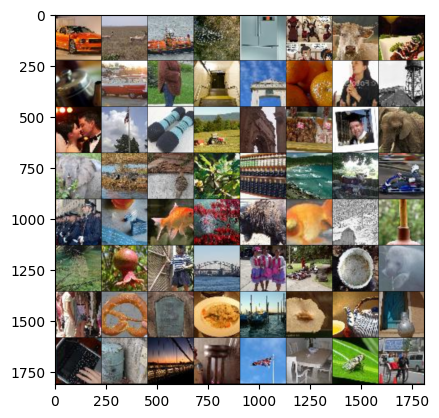

In [12]:
# Display batch of training set images
show_batch(train_loader)

In [13]:
# Create train loader for pre-trained models (normalized based on specific requirements)
train_loader_pretrain = generate_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform_pretrain)

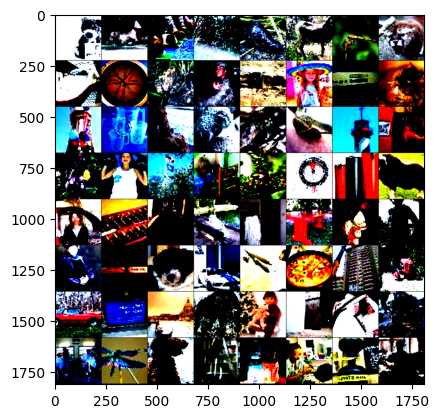

In [14]:
# Display batch of pre-train normalized images
show_batch(train_loader_pretrain)

In [15]:
# Create dataloaders for validation data (depending if model is pretrained)
val_loader = generate_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform)

val_loader_pretrain = generate_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform_pretrain)

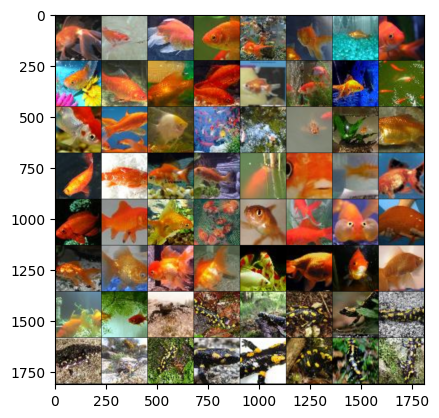

In [16]:
# Display batch of validation images
show_batch(val_loader)

In [17]:
# Define transformations for training and validation data
preprocess_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming preprocess_transform_pretrain is defined earlier as you mentioned

# Create dataloaders for training and validation data
train_loader_pretrain = generate_dataloader(TRAIN_DIR, "train", transform=preprocess_transform_pretrain)
val_loader_pretrain = generate_dataloader(val_img_dir, "val", transform=preprocess_transform_pretrain)

# Define model architecture (using efficientnet-b3 version)
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=200)

# Move model to designated device (Use GPU when on Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define hyperparameters and settings
lr = 0.001  # Initial learning rate
num_epochs = 10  # Number of epochs
log_interval = 300  # Number of iterations before logging
weight_decay = 1e-4  # Weight decay for regularization

# Set loss function (categorical Cross Entropy Loss)
loss_func = nn.CrossEntropyLoss()

# Set optimizer (using RAdam as an alternative to Adam)
optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Set up learning rate scheduler
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Adjust the step_size and gamma as needed

# Setup pytorch-ignite trainer engine
trainer = create_supervised_trainer(model, optimizer, loss_func, device=device)

# Add progress bar to monitor model training
ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"Batch Loss": x})

# Define evaluation metrics
metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(loss_func),
}

# Setup pytorch-ignite evaluator engines
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
# not have exactly similar roles. `evaluator` will save the best model based on
# validation score, whereas `train_evaluator` logs metrics on training set only

# Evaluator for training data
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

# Evaluator for validation data
evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

# Display message to indicate start of training
@trainer.on(Events.STARTED)
def start_message():
    print("Begin training")

# Log results from every batch
@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_batch(trainer):
    batch = (trainer.state.iteration - 1) % trainer.state.epoch_length + 1
    print(
        f"Epoch {trainer.state.epoch} / {num_epochs}, "
        f"Batch {batch} / {trainer.state.epoch_length}: "
        f"Loss: {trainer.state.output:.3f}"
    )

# Evaluate and print training set metrics
@trainer.on(Events.EPOCH_COMPLETED)
def tune_model(trainer):
    lr_scheduler.step()
    print(f"Epoch [{trainer.state.epoch}] - Loss: {trainer.state.output:.2f}")
    train_evaluator.run(train_loader_pretrain)
    epoch = trainer.state.epoch
    metrics = train_evaluator.state.metrics
    print(f"Train - Loss: {metrics['loss']:.3f}, "
          f"Accuracy: {metrics['accuracy']:.3f} "
          )

# Evaluate and print validation set metrics
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_loss(trainer):
    evaluator.run(val_loader_pretrain)
    epoch = trainer.state.epoch
    metrics = evaluator.state.metrics
    print(f"Validation - Loss: {metrics['loss']:.3f}, "
          f"Accuracy: {metrics['accuracy']:.3f}"
          )
    print()
    print("-" * 60)
    print()

# Sets up checkpoint handler to save best n model(s) based on validation accuracy metric
common.save_best_model_by_val_score(
          output_path="best_models",
          evaluator=evaluator,
          model=model,
          metric_name="accuracy",
          n_saved=1,
          trainer=trainer,
          tag="val"
)

# Define a Tensorboard logger
tb_logger = TensorboardLogger(log_dir="logs")

# Using common module to setup tb logger (Alternative method)
# tb_logger = common.setup_tb_logging("tb_logs", trainer, optimizer, evaluators=evaluator)

# Attach handler to plot trainer's loss every n iterations
tb_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED(every=log_interval),
    tag="training",
    output_transform=lambda loss: {"Batch Loss": loss},
)

# Attach handler to dump evaluator's metrics every epoch completed
for tag, evaluator in [("training", train_evaluator), ("validation", evaluator)]:
    tb_logger.attach_output_handler(
        evaluator,
        event_name=Events.EPOCH_COMPLETED,
        tag=tag,
        metric_names="all",
        global_step_transform=global_step_from_engine(trainer),
    )


# Start training
trainer.run(train_loader_pretrain, max_epochs=num_epochs)

# Close Tensorboard
tb_logger.close()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 77.6MB/s]


Loaded pretrained weights for efficientnet-b3
Begin training


[1/1563]   0%|           [00:00<?]

Epoch 1 / 10, Batch 300 / 1563: Loss: 1.431
Epoch 1 / 10, Batch 600 / 1563: Loss: 1.654
Epoch 1 / 10, Batch 900 / 1563: Loss: 1.370
Epoch 1 / 10, Batch 1200 / 1563: Loss: 1.497
Epoch 1 / 10, Batch 1500 / 1563: Loss: 1.886
Epoch [1] - Loss: 1.62
Train - Loss: 1.151, Accuracy: 0.708 
Validation - Loss: 1.463, Accuracy: 0.642

------------------------------------------------------------



[1/1563]   0%|           [00:00<?]

Epoch 2 / 10, Batch 237 / 1563: Loss: 1.656
Epoch 2 / 10, Batch 537 / 1563: Loss: 1.506
Epoch 2 / 10, Batch 837 / 1563: Loss: 1.649
Epoch 2 / 10, Batch 1137 / 1563: Loss: 1.404
Epoch 2 / 10, Batch 1437 / 1563: Loss: 0.999
Epoch [2] - Loss: 1.74
Train - Loss: 1.039, Accuracy: 0.727 
Validation - Loss: 1.498, Accuracy: 0.635

------------------------------------------------------------



[1/1563]   0%|           [00:00<?]

Epoch 3 / 10, Batch 174 / 1563: Loss: 1.737
Epoch 3 / 10, Batch 474 / 1563: Loss: 1.433
Epoch 3 / 10, Batch 774 / 1563: Loss: 1.296
Epoch 3 / 10, Batch 1074 / 1563: Loss: 1.090
Epoch 3 / 10, Batch 1374 / 1563: Loss: 1.220
Epoch [3] - Loss: 1.53
Train - Loss: 1.117, Accuracy: 0.708 
Validation - Loss: 1.619, Accuracy: 0.608

------------------------------------------------------------



[1/1563]   0%|           [00:00<?]

Epoch 4 / 10, Batch 111 / 1563: Loss: 0.902
Epoch 4 / 10, Batch 411 / 1563: Loss: 0.639
Epoch 4 / 10, Batch 711 / 1563: Loss: 0.369
Epoch 4 / 10, Batch 1011 / 1563: Loss: 0.571
Epoch 4 / 10, Batch 1311 / 1563: Loss: 0.535
Epoch [4] - Loss: 0.68
Train - Loss: 0.348, Accuracy: 0.904 
Validation - Loss: 0.989, Accuracy: 0.752

------------------------------------------------------------



[1/1563]   0%|           [00:00<?]

Epoch 5 / 10, Batch 48 / 1563: Loss: 0.494
Epoch 5 / 10, Batch 348 / 1563: Loss: 0.522
Epoch 5 / 10, Batch 648 / 1563: Loss: 0.662
Epoch 5 / 10, Batch 948 / 1563: Loss: 0.472
Epoch 5 / 10, Batch 1248 / 1563: Loss: 0.429
Epoch 5 / 10, Batch 1548 / 1563: Loss: 0.524
Epoch [5] - Loss: 0.64
Train - Loss: 0.227, Accuracy: 0.937 
Validation - Loss: 0.977, Accuracy: 0.763

------------------------------------------------------------



[1/1563]   0%|           [00:00<?]

Epoch 6 / 10, Batch 285 / 1563: Loss: 0.311
Epoch 6 / 10, Batch 585 / 1563: Loss: 0.329
Epoch 6 / 10, Batch 885 / 1563: Loss: 0.165
Epoch 6 / 10, Batch 1185 / 1563: Loss: 0.297
Epoch 6 / 10, Batch 1485 / 1563: Loss: 0.254
Epoch [6] - Loss: 0.40
Train - Loss: 0.151, Accuracy: 0.960 
Validation - Loss: 0.979, Accuracy: 0.763

------------------------------------------------------------



[1/1563]   0%|           [00:00<?]

Epoch 7 / 10, Batch 222 / 1563: Loss: 0.146
Epoch 7 / 10, Batch 522 / 1563: Loss: 0.108
Epoch 7 / 10, Batch 822 / 1563: Loss: 0.062
Epoch 7 / 10, Batch 1122 / 1563: Loss: 0.110
Epoch 7 / 10, Batch 1422 / 1563: Loss: 0.323
Epoch [7] - Loss: 0.32
Train - Loss: 0.123, Accuracy: 0.967 
Validation - Loss: 0.976, Accuracy: 0.768

------------------------------------------------------------



[1/1563]   0%|           [00:00<?]

Epoch 8 / 10, Batch 159 / 1563: Loss: 0.280
Epoch 8 / 10, Batch 459 / 1563: Loss: 0.182
Epoch 8 / 10, Batch 759 / 1563: Loss: 0.483
Epoch 8 / 10, Batch 1059 / 1563: Loss: 0.437
Epoch 8 / 10, Batch 1359 / 1563: Loss: 0.181
Epoch [8] - Loss: 0.27
Train - Loss: 0.110, Accuracy: 0.971 
Validation - Loss: 0.984, Accuracy: 0.771

------------------------------------------------------------



[1/1563]   0%|           [00:00<?]

Epoch 9 / 10, Batch 96 / 1563: Loss: 0.230
Epoch 9 / 10, Batch 396 / 1563: Loss: 0.128
Epoch 9 / 10, Batch 696 / 1563: Loss: 0.233
Epoch 9 / 10, Batch 996 / 1563: Loss: 0.262
Epoch 9 / 10, Batch 1296 / 1563: Loss: 0.201
Epoch [9] - Loss: 0.11
Train - Loss: 0.101, Accuracy: 0.974 
Validation - Loss: 0.985, Accuracy: 0.769

------------------------------------------------------------



[1/1563]   0%|           [00:00<?]

Epoch 10 / 10, Batch 33 / 1563: Loss: 0.332
Epoch 10 / 10, Batch 333 / 1563: Loss: 0.294
Epoch 10 / 10, Batch 633 / 1563: Loss: 0.185
Epoch 10 / 10, Batch 933 / 1563: Loss: 0.226
Epoch 10 / 10, Batch 1233 / 1563: Loss: 0.122
Epoch 10 / 10, Batch 1533 / 1563: Loss: 0.186
Epoch [10] - Loss: 0.13
Train - Loss: 0.100, Accuracy: 0.974 
Validation - Loss: 0.986, Accuracy: 0.768

------------------------------------------------------------



In [18]:
# Display final evaluation metrics on the validation set
evaluator.run(val_loader_pretrain)

print("Final Evaluation Metrics on Validation Set:")
for metric_name, metric_value in evaluator.state.metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")


Final Evaluation Metrics on Validation Set:
accuracy: 0.7698
loss: 0.9887
